## Import Helper Libraries 

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings

In [3]:
from sklearn.preprocessing import MinMaxScaler , RobustScaler , StandardScaler
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB
from sklearn.model_selection import train_test_split , cross_validate
from sklearn.metrics import accuracy_score , plot_confusion_matrix , ConfusionMatrixDisplay, confusion_matrix ,plot_roc_curve , recall_score , f1_score , precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier , VotingClassifier , RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
import joblib

In [4]:
warnings.filterwarnings('ignore')

In [5]:
sns.set_theme(context = 'paper' , style = 'darkgrid' , palette = 'Paired' , 
             rc = {'figure.figsize' : (8 , 4)})

In [6]:
%matplotlib inline

## Read Dataset & Make Some Univariate Analysis To Understand Features 

In [7]:
df = pd.read_csv('train.csv')
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0


In [8]:
df.drop(['employee_id'] , axis = 1 , inplace = True)

## Check Data Info For Missing Values & Show How DataTypes Represent Features 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   region                54808 non-null  object 
 2   education             52399 non-null  object 
 3   gender                54808 non-null  object 
 4   recruitment_channel   54808 non-null  object 
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  50684 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   awards_won?           54808 non-null  int64  
 10  avg_training_score    54808 non-null  int64  
 11  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 5.0+ MB


## Check Missing Records 

In [10]:
df.isnull().mean()*100

department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

## Check Duplicated Data 

In [11]:
df.duplicated().sum()

219

## Drop Missing Records That Have Small Ratio Of Missing & Drop Duplicated Too

In [12]:
df.drop_duplicates(inplace = True , ignore_index = True)

In [13]:
df.dropna(subset = ['education' , 'previous_year_rating'] , axis = 0 , inplace = True)

In [14]:
df.reset_index(inplace = True , drop = True)

## Make Some Univariate Analysis To See Distribution Of Feature & Unique Values 

In [15]:
df['department'].unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='department'>

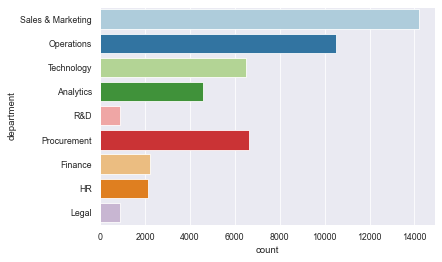

In [16]:
sns.countplot(y = df['department'])

In [17]:
len(df['region'].unique())

34

<AxesSubplot:xlabel='count', ylabel='region'>

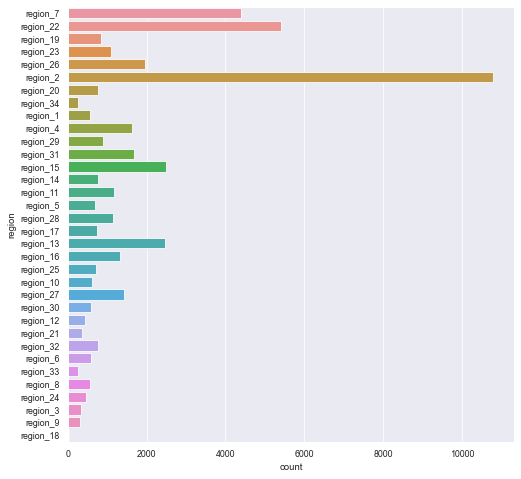

In [18]:
plt.figure(figsize = (8 , 8))
sns.countplot(y = df['region'])

In [19]:
df['education'].unique()

array(["Master's & above", "Bachelor's", 'Below Secondary'], dtype=object)

<AxesSubplot:xlabel='education', ylabel='count'>

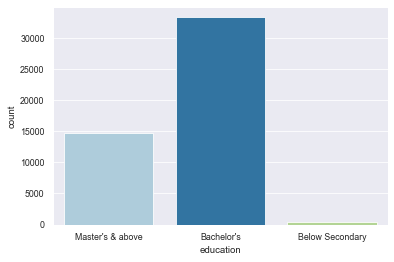

In [20]:
sns.countplot(df['education'])

In [21]:
df['gender'].unique()

array(['f', 'm'], dtype=object)

<AxesSubplot:xlabel='gender', ylabel='count'>

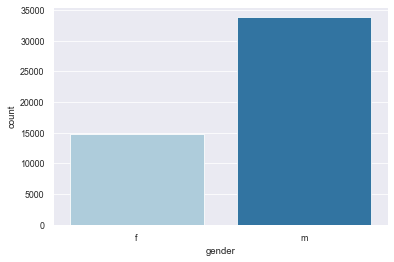

In [22]:
sns.countplot(df['gender'])

In [23]:
df['recruitment_channel'].unique()

array(['sourcing', 'other', 'referred'], dtype=object)

<AxesSubplot:xlabel='recruitment_channel', ylabel='count'>

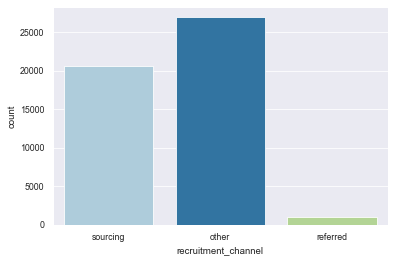

In [24]:
sns.countplot(df['recruitment_channel'])

In [25]:
df['no_of_trainings'].unique()

array([ 1,  2,  3,  4,  7,  5,  6, 10,  8,  9], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='no_of_trainings'>

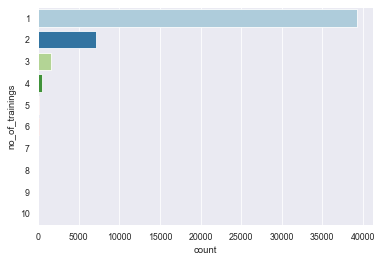

In [26]:
sns.countplot(y = df['no_of_trainings'])

## Convert NumberOfTraining To Interval (Binned)

In [27]:
df['no_of_trainings'] = df['no_of_trainings'].apply(lambda x : '>1' if x > 1 else '1')

In [28]:
df['no_of_trainings'].unique()

array(['1', '>1'], dtype=object)

<AxesSubplot:xlabel='no_of_trainings', ylabel='count'>

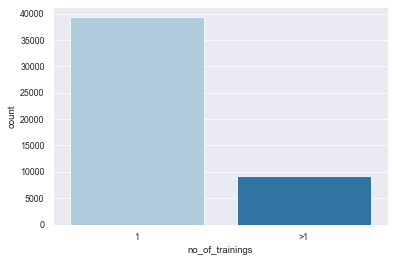

In [29]:
sns.countplot(df['no_of_trainings'])

In [30]:
df['age'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
age,48557.0,35.595836,7.537914,20.0,30.0,34.0,39.0,60.0


<AxesSubplot:xlabel='age', ylabel='Density'>

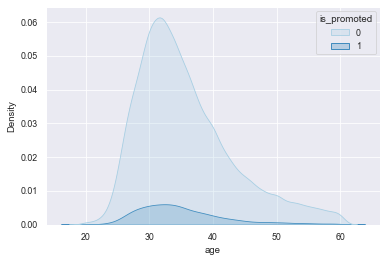

In [31]:
sns.kdeplot(df['age'] , shade = True , hue = df['is_promoted'])

<AxesSubplot:xlabel='age'>

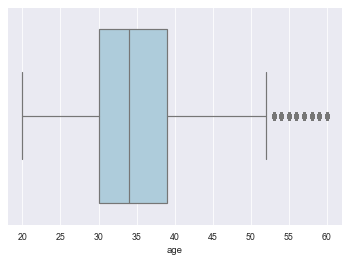

In [32]:
sns.boxplot(df['age'])

## Age With Outliers Points But Is True Values 

In [33]:
df[df['age'] > 52]

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
28,Operations,region_2,Bachelor's,m,sourcing,>1,57,4.0,6,0,58,0
37,HR,region_2,Bachelor's,m,sourcing,1,59,4.0,26,0,52,0
43,Procurement,region_2,Master's & above,f,sourcing,1,56,3.0,12,0,73,0
82,Finance,region_2,Master's & above,m,other,1,60,5.0,17,0,59,0
203,Analytics,region_2,Bachelor's,m,sourcing,>1,54,3.0,9,0,86,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48399,Sales & Marketing,region_2,Bachelor's,m,sourcing,1,57,1.0,13,0,50,0
48402,Analytics,region_2,Master's & above,m,other,1,54,5.0,5,0,87,0
48502,Procurement,region_2,Master's & above,f,sourcing,1,55,4.0,12,0,70,0
48510,Technology,region_7,Master's & above,m,other,1,54,4.0,7,0,81,1


In [34]:
df['previous_year_rating'].unique()

array([5., 3., 1., 4., 2.])

<AxesSubplot:xlabel='previous_year_rating', ylabel='count'>

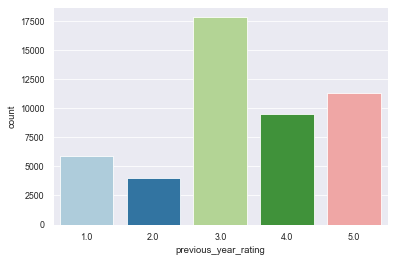

In [35]:
sns.countplot(df['previous_year_rating'])

In [36]:
df['length_of_service'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
length_of_service,48557.0,6.313652,4.206657,1.0,3.0,5.0,8.0,37.0


<AxesSubplot:xlabel='length_of_service', ylabel='Density'>

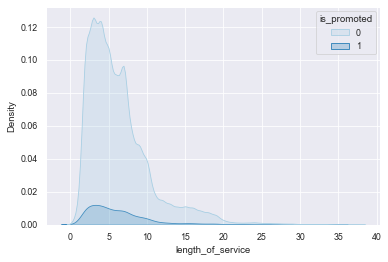

In [37]:
sns.kdeplot(df['length_of_service'] , shade = True , hue = df['is_promoted'])

<AxesSubplot:xlabel='length_of_service'>

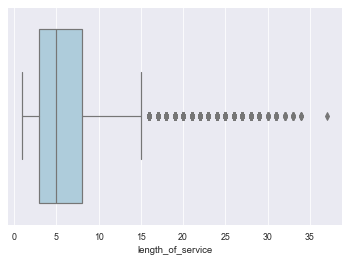

In [38]:
sns.boxplot(df['length_of_service'])

## As Age Feature Outlier Points Is True 

In [39]:
df[df['length_of_service'] > 15]

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
12,Technology,region_29,Master's & above,m,other,>1,39,3.0,16,0,80,0
37,HR,region_2,Bachelor's,m,sourcing,1,59,4.0,26,0,52,0
52,Sales & Marketing,region_4,Master's & above,m,other,1,50,4.0,17,0,47,1
82,Finance,region_2,Master's & above,m,other,1,60,5.0,17,0,59,0
92,Analytics,region_22,Master's & above,m,other,1,42,2.0,19,0,79,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48390,Sales & Marketing,region_2,Master's & above,f,other,1,57,5.0,24,0,49,0
48392,Sales & Marketing,region_30,Master's & above,m,sourcing,1,47,2.0,16,0,47,0
48452,Analytics,region_2,Master's & above,m,sourcing,1,47,5.0,19,0,86,0
48455,Operations,region_2,Bachelor's,f,other,>1,52,5.0,18,0,56,1


In [40]:
df['awards_won?'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='awards_won?', ylabel='count'>

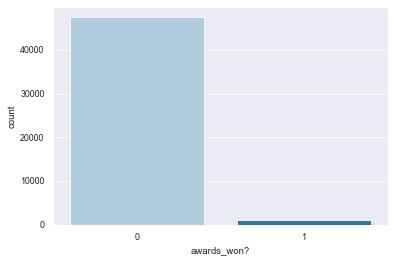

In [41]:
sns.countplot(df['awards_won?'])

In [42]:
df['avg_training_score'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
avg_training_score,48557.0,63.61157,13.276493,39.0,51.0,60.0,76.0,99.0


<AxesSubplot:xlabel='avg_training_score', ylabel='Density'>

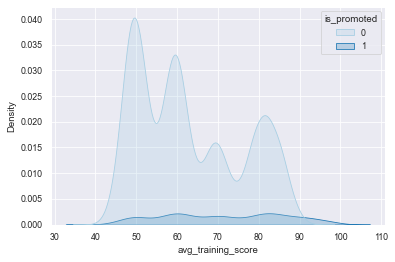

In [43]:
sns.kdeplot(df['avg_training_score'] , shade = True , hue = df['is_promoted'])

<AxesSubplot:xlabel='avg_training_score'>

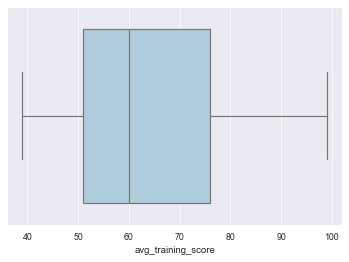

In [44]:
sns.boxplot(df['avg_training_score'])

In [45]:
df['is_promoted'].unique()

array([0, 1], dtype=int64)

In [46]:
df['is_promoted'].value_counts()

0    44326
1     4231
Name: is_promoted, dtype: int64

## Imbalanced Class :(

<AxesSubplot:xlabel='is_promoted', ylabel='count'>

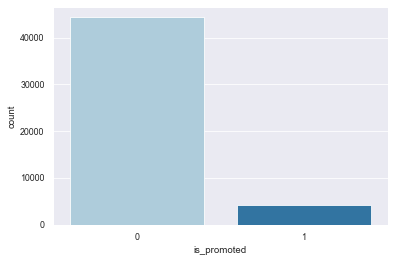

In [47]:
sns.countplot(df['is_promoted'])

## Correlation Between Features 

<AxesSubplot:>

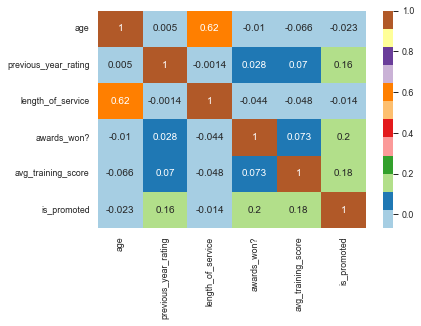

In [48]:
sns.heatmap(df.select_dtypes('number').corr()  , annot = True , cmap = 'Paired')

## Map Education Into Labels 

In [49]:
mapper = {'Below Secondary' : 1 , "Bachelor's" : 2 , "Master's & above" : 3}
df['education'] = df['education'].map(mapper)

## Use OneHot & Binary Encoder To Encode Our Categorical Feature  

In [50]:
col_to_Bencdr = ['department' , 'region']
col_to_OHEencdr = ['gender' , 'recruitment_channel' , 'no_of_trainings']

In [51]:
OHE = OneHotEncoder(sparse = False , drop = 'first')
Bin = BinaryEncoder()

In [52]:
df = pd.concat([df , pd.DataFrame(data = OHE.fit_transform(df[col_to_OHEencdr]),
                                  columns=OHE.get_feature_names_out() )] , axis = 1 )

In [53]:
df = pd.concat([df , Bin.fit_transform(df[col_to_Bencdr])] , axis = 1 )

In [54]:
df.drop(col_to_Bencdr + col_to_OHEencdr , axis = 1 , inplace = True)

## We Can Use Column Transformer In PipeLine Too

In [55]:
encoder = ColumnTransformer(transformers = [('Bin_encoder' ,BinaryEncoder(),col_to_Bencdr )
                                            , ('OHE_encoder' ,
                                               OneHotEncoder(sparse = False , drop = 'first'),
                                               col_to_OHEencdr)] , remainder = 'passthrough')
encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('Bin_encoder', BinaryEncoder(),
                                 ['department', 'region']),
                                ('OHE_encoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['gender', 'recruitment_channel',
                                  'no_of_trainings'])])

In [56]:
x = df.drop(['is_promoted'] , axis = 1)
y = df['is_promoted']

## Use SmoteTomek To Balance Our Class 

In [57]:
smt = SMOTETomek(tomek = TomekLinks(sampling_strategy = 'auto'))

In [58]:
x , y = smt.fit_resample(x , y)

## List Of Models To Compare & Choose Best One 

In [59]:
models = []
models.append(('DT' , DecisionTreeClassifier(max_depth = 18)))
models.append(('BaggingDT' , BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 16) , n_estimators = 10)))
models.append(('RF' , RandomForestClassifier()))
models.append(('ADBoosting' , AdaBoostClassifier()))
models.append(('GradiantBoosting' , GradientBoostingClassifier()))
models.append(('XGB' , XGBClassifier()))
models.append(('Voter' , VotingClassifier(estimators = [models[0] , models[1] , models[2] , models[3] , models[4]] , voting = 'hard')))
models.append(('SVC' , SVC(kernel = 'poly' , degree = 4)))
models.append(('LR' , LogisticRegression()))
models.append(('NB' , MultinomialNB()))
models.append(('KNN' , KNeighborsClassifier(n_neighbors = 31)))

In [60]:
scoring = ['accuracy','f1','recall','precision']

### Run Models Using PipeLine & Use Cross Validation To See Which Model Is The Best Generally On Data 

In [304]:
for model in models :
    steps = []
    if model[0] == 'NB':
        steps.append(('scalr' , MinMaxScaler()))
    else :
        steps.append(('scalr' , StandardScaler()))
    if model[0] == 'LR':
        steps.append(('poly' , PolynomialFeatures(degree = 3)))
    steps.append(model)
    PL = Pipeline(steps = steps)
    scores = cross_validate(estimator = PL , X = x , y = y , cv = 5 , return_train_score = True , scoring = scoring)
    print('*'*40)
    print(model[0])
    print('Train Acc : ' , scores['train_accuracy'].mean())
    print('Test Acc  : ', scores['test_accuracy'].mean())
    print('Train F1_Score : ' , scores['train_f1'].mean())
    print('Test F1_Score  : ', scores['test_f1'].mean())

****************************************
DT
Train Acc :  0.9627319378157017
Test Acc  :  0.9113065057769081
Train F1_Score :  0.9623072946698938
Test F1_Score  :  0.9071946874206285
****************************************
BaggingDT
Train Acc :  0.9616626364557975
Test Acc  :  0.9346453503708414
Train F1_Score :  0.9607295772610038
Test F1_Score  :  0.9280075468080291
****************************************
RF
Train Acc :  0.9997206799438316
Test Acc  :  0.9543388935604147
Train F1_Score :  0.9997205488135785
Test F1_Score  :  0.9481103460514255
****************************************
ADBoosting
Train Acc :  0.8907520230684851
Test Acc  :  0.8841307963308267
Train F1_Score :  0.8877640835612712
Test F1_Score  :  0.8728637035319606
****************************************
GradiantBoosting
Train Acc :  0.9203796880979832
Test Acc  :  0.9146247003859831
Train F1_Score :  0.9163948826788749
Test F1_Score  :  0.9031489096965224
****************************************
XGB
Train Acc :  0.9

## RandomForestClassifier Is The Best One Now Time For Split Data Into Train & Test

In [263]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 10 , stratify = y)

In [264]:
steps = []
steps.append(('RF' , RandomForestClassifier(n_estimators = 120)))

In [265]:
PL = Pipeline(steps = steps)

In [266]:
PL.fit(x_train , y_train)

Pipeline(steps=[('RF', RandomForestClassifier(n_estimators=120))])

In [267]:
y_train_prd = PL.predict(x_train)

## Train ACC

In [268]:
accuracy_score(y_true = y_train , y_pred = y_train_prd)

0.999689625010581

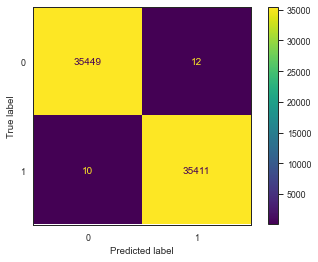

In [269]:
sns.set_style('white')
plot_confusion_matrix(PL , x_train , y_train)

## F1 Score To See Performence Of Model On 2 Classes (very Good)

In [270]:
f1_score(y_true = y_train , y_pred = y_train_prd)

0.999689458528598

In [271]:
y_test_prd = PL.predict(x_test)

## Test ACC

In [272]:
accuracy_score(y_true = y_test , y_pred = y_test_prd)

0.9617967383330512

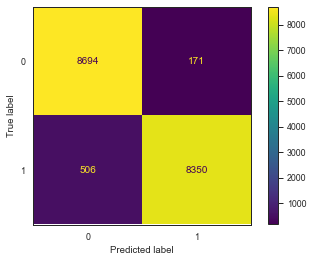

In [273]:
plot_confusion_matrix(PL , x_test , y_test)

## Very Good Performence On 2 Classes in Test Data 

In [274]:
f1_score(y_true = y_test , y_pred = y_test_prd)

0.9610404557748748

## Save Pipeline That Has Model 

In [275]:
joblib.dump(PL , 'Model.pkl')